# Рекомендация тарифов

Оператор мобильной связи хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

## Загрузка и подготовка данных

In [54]:
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns 
import statsmodels.api as sm
import numpy as np
import warnings
from plotly.subplots import make_subplots
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFE
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [55]:
warnings.filterwarnings('ignore')

In [56]:
df = pd.read_csv('users_behavior.csv')

In [57]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


*Как мы видим из таблицы выше, у нас есть 4 признака, чтобы классифицировать подходящий тариф: количество звонков, продолжительность разговоров в минутах, количество смс и потраченных Гб.*

*Разделим датасет по тарифам: "Смарт" и "Ультра"*

In [58]:
df_smart = df[df['is_ultra'] == 0].drop('is_ultra',axis=1)

In [59]:
df_smart.describe()

,calls,minutes,messages,mb_used
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,58.463437,405.942952,33.384029,16208.466949
std,25.939858,184.512604,28.227876,5870.498853
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.230000,10.000000,12643.050000
50%,60.000000,410.560000,28.000000,16506.930000
75%,76.000000,529.510000,51.000000,20043.060000
max,198.000000,1390.220000,143.000000,38552.620000


In [60]:
df_ultra = df[df['is_ultra'] == 1].drop('is_ultra',axis=1)

In [61]:
df_ultra.describe()

,calls,minutes,messages,mb_used
count,985.000000,985.000000,985.000000,985.000000
mean,73.392893,511.224569,49.363452,19468.823228
std,43.916853,308.031100,47.804457,10087.178654
min,0.000000,0.000000,0.000000,0.000000
25%,41.000000,276.030000,6.000000,11770.280000
50%,74.000000,502.550000,38.000000,19308.010000
75%,104.000000,730.050000,79.000000,26837.720000
max,244.000000,1632.060000,224.000000,49745.730000


In [62]:
pd.pivot_table(df, columns='is_ultra', aggfunc=['mean','median']).reset_index().head()

index          mean                  median          
is_ultra                       0             1         0         1
0            calls     58.463437     73.392893     60.00     74.00
1          mb_used  16208.466949  19468.823228  16506.93  19308.01
2         messages     33.384029     49.363452     28.00     38.00
3          minutes    405.942952    511.224569    410.56    502.55

*Из таблицы видим, что пользователи "Ультра" пользуются всеми возможностями пакетов чаще, от смс до Гб*

*Посмотрим распределение признаков и заодно построим qqplot, чтобы оценить насколько оно близко к нормльному. Одной из моделей будет Гауссовский Байесовский классификатор, улсовие применения которого заключается в нормалньом распределнии признаков.*

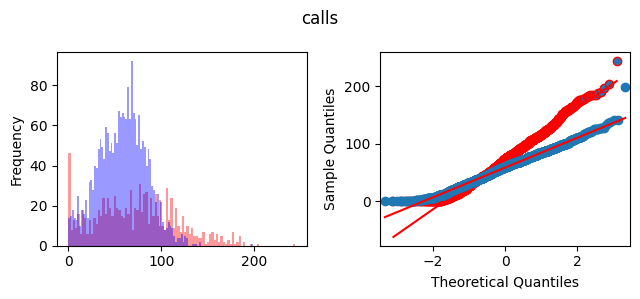

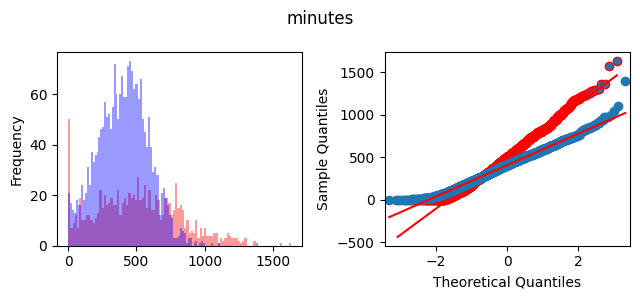

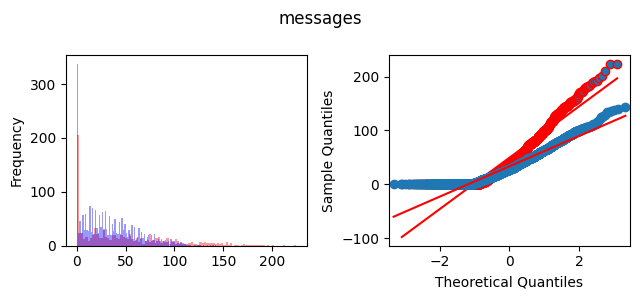

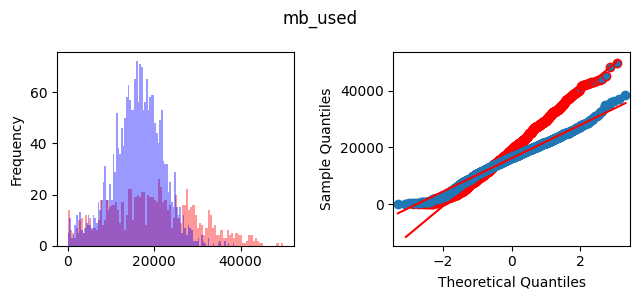

In [69]:
for column in df.columns[:-1]: 
    fig, axes = plt.subplots(1, 2, figsize=(6.5, 3))
    plt.suptitle(column)
    df_ultra[column].plot(kind="hist",bins=100, color='r', alpha=0.4,ax=axes[0])
    df_smart[column].plot(kind="hist",bins=100, color='b', alpha=0.4, ax=axes[0])
    sm.qqplot(df_ultra[column],color='r',line='s',markeredgecolor='r',ax=axes[1])
    sm.qqplot(df_smart[column],line='s',ax=axes[1])
    plt.tight_layout()
    plt.show()

*Мы видим, что для каждого способа связи есть большие выбросы в нуле. Уберем их и посмотрим, как изменились данные.Также распределения близки к нормальным за исключением области близкой к нулю. Рапсределение смс наиболее хаотичное.*

In [11]:
ultra = df_ultra
smart = df_smart

for column in df.columns[:-1]:   
    ultra[column] = ultra[ultra[column] > 0][column]
    smart[column] = smart[smart[column] > 0][column]

*Таким образом мы заменили нули Nan. Теперь удалим такие строки.*

In [12]:
df_ultra.shape

(985, 4)

In [13]:
ultra.dropna(inplace=True)

In [14]:
df_smart.shape

(2229, 4)

In [15]:
smart.dropna(inplace=True)

*Как мы видим при удалении теряется большая доля данных, но это позволит улучшить предсказание за счет удаления выброса.*

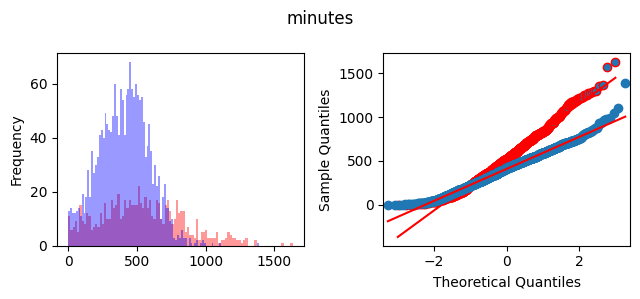

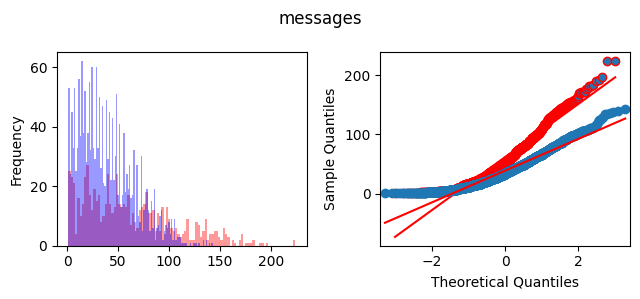

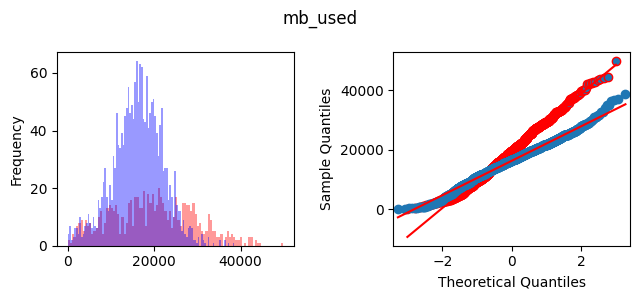

In [113]:
for column in df.columns[:-1]: 
    fig, axes = plt.subplots(1, 2, figsize=(6.5, 3))
    plt.suptitle(column)
    ultra[column].plot(kind="hist",bins=100, color='r', alpha=0.4,ax=axes[0])
    smart[column].plot(kind="hist",bins=100, color='b', alpha=0.4, ax=axes[0])
    sm.qqplot(ultra[column],color='r',line='s',markeredgecolor='r',ax=axes[1])
    sm.qqplot(smart[column],line='s',ax=axes[1])
    plt.tight_layout()
    plt.show()

*Проверим признаки на мультиколлинеарность*

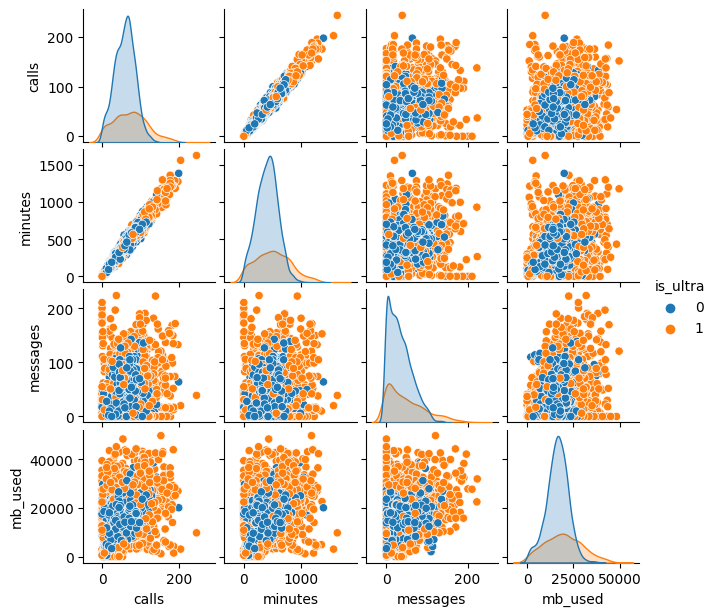

In [82]:
pp = sns.pairplot(df, hue='is_ultra',aspect=.85)
pp.fig.set_size_inches(7,6)
plt.show()

interval columns not set, guessing: ['calls', 'minutes', 'messages', 'mb_used', 'is_ultra']


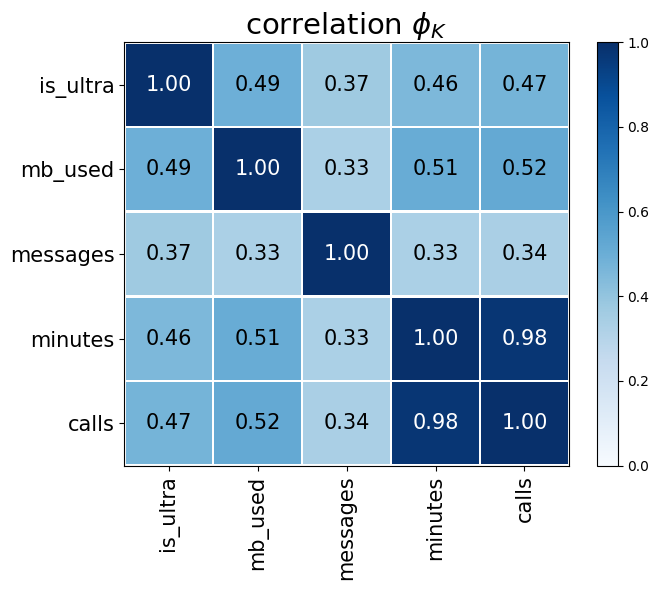

In [87]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(7, 6))

*Матрица корреляций показала, что признаки количество и длительность звонков коррелируют на 97-99%. Наблюдается мультиколлинеарность между признакми. Поэтому также проверим на обученных моделях вклад признаков в качество модели.*

**Вывод: для классификации тарифов у нас есть 4 признака, пара которых сильно коррелирует. У каждого признака есть пик в нуле, что может сказаться на обучении модели. Чтобы учесть это мы будем строить модель на двух сетах, с отфильтрованными данными и нет. В первом случае это значительно уменьшит количество данных, но избавит нас от выброса в нуле.**

## Подготовка выборок

*Разобьем данные на тренировочную, валидационную и проверочную выброки. Так как данных мало будем, делить их соответственно на 70%, 15%, 15%*

In [88]:
df_full = df.dropna()

In [89]:
df.drop('calls',axis=1, inplace=True)

In [90]:
df.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


In [91]:
feature = df.drop('is_ultra', axis=1)
target = df['is_ultra']

*Отфильтруем нули*

In [92]:
df_filter = df
for column in df_filter.columns[:-1]:   
    df_filter[column] = df[df[column] > 0][column]

In [93]:
df_filter = df_filter.dropna()

In [94]:
df_filter.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


In [95]:
feature_f = df_filter.drop('is_ultra', axis=1)
target_f = df_filter['is_ultra']

In [96]:
feature_train, feature_val, target_train, target_val = train_test_split(feature, target, 
                                                    train_size=0.7, 
                                                    random_state=123,
                                                    stratify=target)
# feature_f, target_f = ff, tf
ff_train, ff_val, tf_train, tf_val = train_test_split(feature_f, target_f, 
                                                    train_size=0.7, 
                                                    random_state=123,
                                                    stratify=target_f)

In [97]:
feature_test, feature_val, target_test, target_val = train_test_split(feature_val, target_val, 
                                                    train_size=0.5, 
                                                    random_state=123,
                                                    stratify=target_val)
ff_test, ff_val, tf_test, tf_val = train_test_split(ff_val, tf_val, 
                                                    train_size=0.5, 
                                                    random_state=123,
                                                    stratify=tf_val)

In [98]:
ff_train.shape

(1866, 3)

In [99]:
ff_test.shape

(400, 3)

In [100]:
ff_val.shape

(401, 3)

*Проверим с помощью модели случайного леса вклад от признаков*

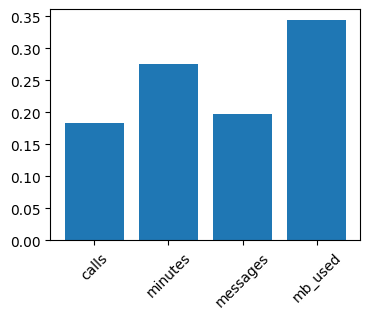

In [108]:
feature_full = df_full.drop('is_ultra', axis=1)
target_full = df_full['is_ultra']
full_train, full_val, targe_train_f, target_val_f = train_test_split(feature_full, target_full, 
                                                    train_size=0.7, 
                                                    random_state=123,
                                                    stratify=target)
clf = RandomForestClassifier()
clf.fit(full_train,targe_train_f)
# create a figure to plot a bar, where x axis is features, and Y indicating the importance of each feature
plt.figure(figsize=(4,3))
plt.bar(full_train.columns, clf.feature_importances_)
plt.xticks(rotation=45)
plt.show()

*Количество звонков и сообщения вносят одинаковый вклад в модель. Однако, прогонка разных комбинаций показало, что оставление количества звонков ухудшала все модели. Поэтому количество звонков было убрано. Это объясняется тем, что минуты и количество звонков сильно коррелируют. Клиенты покупают именно минуты и расчитывают количество звонков, исходя из этой величины, а не наоборот. Поэтому минуты первичны - если их мало, звонят реже.*

**Вывод: мы подготовили датасеты для обучения наших моделей, для обучения будем использовать 1866 строк с 3 признаками, для валидации и теста по 400 и 401**

## Обучение моделей

*В  работе мы проверим 4 модели, варьируя их параметры*
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier
- GaussianNB

*Начнем с логистической регрссиии*

In [115]:
model = LogisticRegression(random_state=123)
model.fit(feature_train,target_train)
predictions_valid = model.predict(feature_val)

In [116]:
round(accuracy_score(target_val, predictions_valid),2)

0.76

In [117]:
model.fit(ff_train,tf_train)
predictions_valid = model.predict(ff_val)
accuracy = accuracy_score(tf_val, predictions_valid)
round(accuracy,2)

0.78

*Доля правильных ответов нам мало поможет в нахождении лучшей модели, так как наши классы несоразмерны. Поэтом мы будем также считать точность и полноту. Возьмем в случае полноты бету равную 1. Так как непонятно какой штраф назначить, в случае если мы пропустим тариф Ультра. Если бы мы знали стоимость тарифов, мы могли бы оценить потерю выгоды и из этих соображений задать бету.*

In [118]:
report = classification_report(tf_val, predictions_valid, target_names=['Smart', 'Ultra'])
print(report)

              precision    recall  f1-score   support

       Smart       0.78      0.97      0.86       288
       Ultra       0.77      0.29      0.42       113

    accuracy                           0.78       401
   macro avg       0.77      0.63      0.64       401
weighted avg       0.77      0.78      0.74       401



*Посомтрим влияет ли выбор метода расчета на точность*

In [122]:
solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
data = {'solver':[],'accuracy':[],'precision':[],'recall':[]}
for solver in solvers:
    model = LogisticRegression(solver=solver, random_state=123,max_iter=100000)
    model.fit(ff_train, tf_train)
    prediction = model.predict(ff_val)
    data['solver'].append(solver)
    data['accuracy'].append(accuracy_score(tf_val, prediction))
    data['precision'].append(precision_score(tf_val, prediction))
    data['recall'].append(recall_score(tf_val, prediction))

In [123]:
pd.DataFrame(data)

,solver,accuracy,precision,recall
0,lbfgs,0.775561,0.767442,0.292035
1,liblinear,0.740648,0.621622,0.203540
2,sag,0.745636,0.677419,0.185841
3,saga,0.740648,0.655172,0.168142


*Метод расчета логистической регрессии влияет на точность. Установленный по умолчанию lbfgs работает значительно лучше - на 3%*

*Приступим к модели дерева решений*

In [124]:
data = {'max_features':[],'max_depth':[],'accuracy':[],'precision':[],'recall':[]}
for i in ['auto', 'sqrt', 'log2']:
    for depth in range(1, 20, 2):
        model = DecisionTreeClassifier(random_state=123, max_depth=depth, max_features=i)
        model.fit(ff_train, tf_train)
        prediction = model.predict(ff_val)
        data['max_features'].append(i)
        data['max_depth'].append(depth)
        data['accuracy'].append(accuracy_score(tf_val, prediction))
        data['precision'].append(precision_score(tf_val, prediction))
        data['recall'].append(recall_score(tf_val, prediction))

In [128]:
pd.DataFrame(data).head(10)

,max_features,max_depth,accuracy,precision,recall
0,auto,1,0.753117,0.666667,0.247788
1,auto,3,0.783042,0.724138,0.371681
2,auto,5,0.770574,0.640000,0.424779
3,auto,7,0.795511,0.712329,0.460177
4,auto,9,0.783042,0.696970,0.407080
5,auto,11,0.798005,0.735294,0.442478
6,auto,13,0.793017,0.692308,0.477876
7,auto,15,0.768080,0.606383,0.504425
8,auto,17,0.730673,0.523364,0.495575
9,auto,19,0.740648,0.545455,0.477876


*Исходя из сочетания парметров наибольшая полнота с высокой точностью наблюдается около глубины дерева раной 7 и 15. Теперь будем варьировать минимальное количество веток в узле для гулбины от 1 до 8 (так как шаг был равен двум поэтому макисмум у нас с ошибкой +-1), так как данных мало и дерево в районе 15 скорее приведет к переобучению, чем к улучшению. А также посмотрим как выбор разделения повлияет на качество модели. Метод random показал себя лучше остальных.*

*И так же проверим улучшает ли столбец с смс нашу модель.*

In [129]:
data = {'splitter':[],'min_samples_split':[],'max_depth':[],'accuracy':[],'precision':[],'recall':[],'f1_score':[]}
for splitter in ['best', 'random']:
    for min_samples_split in range(2,5):
        for depth in range(2,11):
            model = DecisionTreeClassifier(random_state=123, max_depth=depth, splitter=splitter,min_samples_split=min_samples_split)
            model.fit(ff_train.drop('messages',axis=1), tf_train)
            prediction = model.predict(ff_val.drop('messages',axis=1))
            data['splitter'].append(splitter)
            data['min_samples_split'].append(min_samples_split)
            data['max_depth'].append(depth)
            data['accuracy'].append(accuracy_score(tf_val, prediction))
            data['precision'].append(precision_score(tf_val, prediction))
            data['recall'].append(recall_score(tf_val, prediction))
            data['f1_score'].append(f1_score(tf_val, prediction))

In [130]:
data_tree = pd.DataFrame(data)

In [131]:
data_tree[data_tree['f1_score'] > 0.53]

,splitter,min_samples_split,max_depth,accuracy,precision,recall,f1_score
32,random,2,7,0.788030,0.705882,0.424779,0.530387
52,random,4,9,0.793017,0.734375,0.415929,0.531073


In [132]:
data = {'splitter':[],'min_samples_split':[],'max_depth':[],'accuracy':[],'precision':[],'recall':[],'f1_score':[]}
for splitter in ['best', 'random']:
    for min_samples_split in range(2,5):
        for depth in range(2,11):
            model = DecisionTreeClassifier(random_state=123, max_depth=depth, splitter=splitter,min_samples_split=min_samples_split)
            model.fit(ff_train, tf_train)
            prediction = model.predict(ff_val)
            data['splitter'].append(splitter)
            data['min_samples_split'].append(min_samples_split)
            data['max_depth'].append(depth)
            data['accuracy'].append(accuracy_score(tf_val, prediction))
            data['precision'].append(precision_score(tf_val, prediction))
            data['recall'].append(recall_score(tf_val, prediction))
            data['f1_score'].append(f1_score(tf_val, prediction))

In [133]:
data_tree = pd.DataFrame(data)

In [134]:
data_tree[data_tree['f1_score'] > 0.58]

,splitter,min_samples_split,max_depth,accuracy,precision,recall,f1_score
31,random,2,6,0.800499,0.708861,0.495575,0.583333
32,random,2,7,0.817955,0.777778,0.495575,0.605405
35,random,2,10,0.822943,0.800000,0.495575,0.612022
40,random,3,6,0.800499,0.708861,0.495575,0.583333
41,random,3,7,0.822943,0.776316,0.522124,0.624339
50,random,4,7,0.810474,0.760563,0.477876,0.586957


*Лучшее сочетание полноты и доли правильных ответов у модели 41. Также будем держать модель 32 в фокусе из-за минимального разделения в узле = 2 при той же глубине. Доля верных ответов у моделей 82,3% и 81,8%. Признак количества смс улучшает модель, но не вносит основной вклад (смс-сообщения мертвы и нет им спасения)*

*Перейдем к модели случайного леса. Максимальную глубину выберем равной 10, так как дерево решений показало, что при глубине выше 7 показатели колеблются на том же уровне (но оставим зазор в 3 единицы на всякий случай). Количество деревьеd будем изменять до 30*

In [135]:
data = {'n_estimators':[],'max_depth':[],'accuracy':[],'precision':[],'recall':[],'f1_score':[]}

for n in range(2,30,2):
    for depth in range(1, 10):
        model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=123)
        model.fit(ff_train, tf_train)
        prediction = model.predict(ff_val)
        data['n_estimators'].append(n)
        data['max_depth'].append(depth)
        data['accuracy'].append(accuracy_score(tf_val, prediction))
        data['precision'].append(precision_score(tf_val, prediction))
        data['recall'].append(recall_score(tf_val, prediction))
        data['f1_score'].append(f1_score(tf_val, prediction))

In [136]:
data_random = pd.DataFrame(data)

In [137]:
data_random[data_random['f1_score'] > 0.64]

,n_estimators,max_depth,accuracy,precision,recall,f1_score
43,10,8,0.830424,0.784810,0.548673,0.645833
79,18,8,0.830424,0.792208,0.539823,0.642105
88,20,8,0.830424,0.792208,0.539823,0.642105
106,24,8,0.835411,0.805195,0.548673,0.652632
115,26,8,0.830424,0.792208,0.539823,0.642105


*Проверим лес при гораздо большем лесе*

In [138]:
data = {'n_estimators':[],'max_depth':[],'accuracy':[],'precision':[],'recall':[],'f1_score':[]}

for n in range(2,300,10):
    for depth in range(1, 15):
        model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=123)
        model.fit(ff_train, tf_train)
        prediction = model.predict(ff_val)
        data['n_estimators'].append(n)
        data['max_depth'].append(depth)
        data['accuracy'].append(accuracy_score(tf_val, prediction))
        data['precision'].append(precision_score(tf_val, prediction))
        data['recall'].append(recall_score(tf_val, prediction))
        data['f1_score'].append(f1_score(tf_val, prediction))
data_random = pd.DataFrame(data)

In [139]:
data_random = pd.DataFrame(data)
data_random[data_random['f1_score'] > 0.64]

,n_estimators,max_depth,accuracy,precision,recall,f1_score
23,12,10,0.830424,0.792208,0.539823,0.642105
38,22,11,0.830424,0.777778,0.557522,0.649485
39,22,12,0.832918,0.794872,0.548673,0.649215
52,32,11,0.835411,0.805195,0.548673,0.652632
53,32,12,0.832918,0.810811,0.530973,0.641711
94,62,11,0.830424,0.792208,0.539823,0.642105
105,72,8,0.832918,0.787500,0.557522,0.652850
108,72,11,0.832918,0.802632,0.539823,0.645503
192,132,11,0.832918,0.810811,0.530973,0.641711


*Случайны лес показал незначительное улучшение модели: доля верных ответов поднялась на уровень 83%, полнота до 55.Видна особенность, что глубина деревьев равная 8  показала все лучшие результаты. Оставим ее и количество деревье равное 10 и 24 (чтобы посмотреть переобучение это или нет). Значительное увеличение леса не привело  к улучшению модели (не смотря на то что количество деревье увеличось в 3 раз  с 24 до 72)*

*Применим байесовскую модель*

In [140]:
data = {'accuracy':[],'precision':[],'recall':[],'f1_score':[]}
model = GaussianNB()
model.fit(ff_train, tf_train)
prediction = model.predict(ff_val)
data['accuracy'].append(accuracy_score(tf_val, prediction))
data['precision'].append(precision_score(tf_val, prediction))
data['recall'].append(recall_score(tf_val, prediction))
data['f1_score'].append(f1_score(tf_val, prediction))

In [141]:
pd.DataFrame(data)

,accuracy,precision,recall,f1_score
0,0.778055,0.662162,0.433628,0.524064


*Байес показал хороший результат, но мы добились больших показателей, применив дерево решений и лес. Также были прогнаны другие модели: ближайших соседей, линейный дискриминантный анализ, SVC и еще парочка, однако при стандартных настройках они показали значительно более низкие результаты. Поэтому они были отвергнуты*

*В итоге у нас остались два подхода - дерево решений и лес, в каждом из которых есть две модели*

## Проверьте модель на тестовой выборке

Лучшая модель - случайный лес

In [146]:
model = RandomForestClassifier(n_estimators=10, max_depth=8, random_state=123)

In [147]:
data = {'model':[],'accuracy':[],'precision':[],'recall':[],'f1_score':[]}
model.fit(ff_train, tf_train)
prediction = model.predict(ff_test)
data['model'].append(f'model_{i}')
data['accuracy'].append(accuracy_score(tf_test, prediction))
data['precision'].append(precision_score(tf_test, prediction))
data['recall'].append(recall_score(tf_test, prediction))
data['f1_score'].append(f1_score(tf_test, prediction)) 

In [148]:
ans = pd.DataFrame(data)
ans

,model,accuracy,precision,recall,f1_score
0,model_3,0.805,0.769231,0.442478,0.561798


**Вывод: лучшей моделью оказалась модель случайного леса с 24 деревьями и глубинной равной 8. Модель продемонстировала высокую долю верных ответов 83%, точность 80% и достаточную полноту 55%. Стоит заметить, что близкие значения показала простая модель дерева решений с глубиной равной 7 и минималным количеством ветвей в узле - 3. Дерево решний показало такую же долю верных ответов и даже большую точность. Поэтому я бы рекомендовал ее или модель леса с 10 деревьями. Хотя у нее ниже полнота, но если это не сильно отразится на прибыле, так как они проще, интерпретируемее и быстрее (конечно, я понимаю что сейчас модель что та что другая считается моментально  и совет больше абстрактный, нежели практический ). Но для начала проеврим эти две модели на адекватность.**

## Проверка модели на адекватность

In [145]:
data1 = {'model':[' DummyClassifier'],'accuracy':[],'precision':[],'recall':[],'f1_score':[]}
model = DummyClassifier()
model.fit(ff_train, tf_train)
prediction = model.predict(ff_test)
data1['accuracy'].append(accuracy_score(tf_test, prediction))
data1['precision'].append(precision_score(tf_test, prediction))
data1['recall'].append(recall_score(tf_test, prediction))
data1['f1_score'].append(f1_score(tf_test, prediction)) 
pd.DataFrame(data1)

,model,accuracy,precision,recall,f1_score
0,DummyClassifier,0.7175,0.0,0.0,0.0


**Итоговый вывод: в работе были исследованы данные поведения клиентов при выборе тарифов на связь. Были устранены выбросы в нуле. Проверtны признаки на мултиколинеарность, почти 100% корреляцию показали количество и продолжительность звонков. Из-за этого при построение модели данные количества звонков не учитывались. Были изученны модели классификации, наилучшие результаты показали модель леса и моедль дерева решений. Варьированием гиперпараметров были найдены лучшие сочетания. Наилучшей моделью оказалась модель леса с 24 деревьями и глубинной дерева равной 8 (модель 3). Стоит также заметить, что дерево решений глубиной 7 и минимальным количеством делений в узе равное 3 показала также выоские показатели (модель 1) при значительно большей простоте. Ниже представленны результаты**